In [303]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib as mpl
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
os.environ["OMP_NUM_THREADS"] = '1'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'

In [688]:
water = pd.read_csv('C:/k_digital/source/data/data_city/data_tr_city.csv')

In [689]:
water['target'] = water['구미 혁신도시배수지 유출유량 적산차']
water = water.drop('구미 혁신도시배수지 유출유량 적산차', axis=1)

In [690]:
water['datetime'] = water['datetime'].astype('datetime64[ns]')

In [691]:
water = water.set_index('datetime')
water

,target
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


In [692]:
water.index = water.index.to_period('h')

In [693]:
water.index

PeriodIndex(['2017-01-01 01:00', '2017-01-01 02:00', '2017-01-01 03:00',
             '2017-01-01 04:00', '2017-01-01 05:00', '2017-01-01 06:00',
             '2017-01-01 07:00', '2017-01-01 08:00', '2017-01-01 09:00',
             '2017-01-01 10:00',
             ...
             '2020-12-31 14:00', '2020-12-31 15:00', '2020-12-31 16:00',
             '2020-12-31 17:00', '2020-12-31 18:00', '2020-12-31 19:00',
             '2020-12-31 20:00', '2020-12-31 21:00', '2020-12-31 22:00',
             '2020-12-31 23:00'],
            dtype='period[H]', name='datetime', length=35063)

<AxesSubplot:xlabel='datetime'>

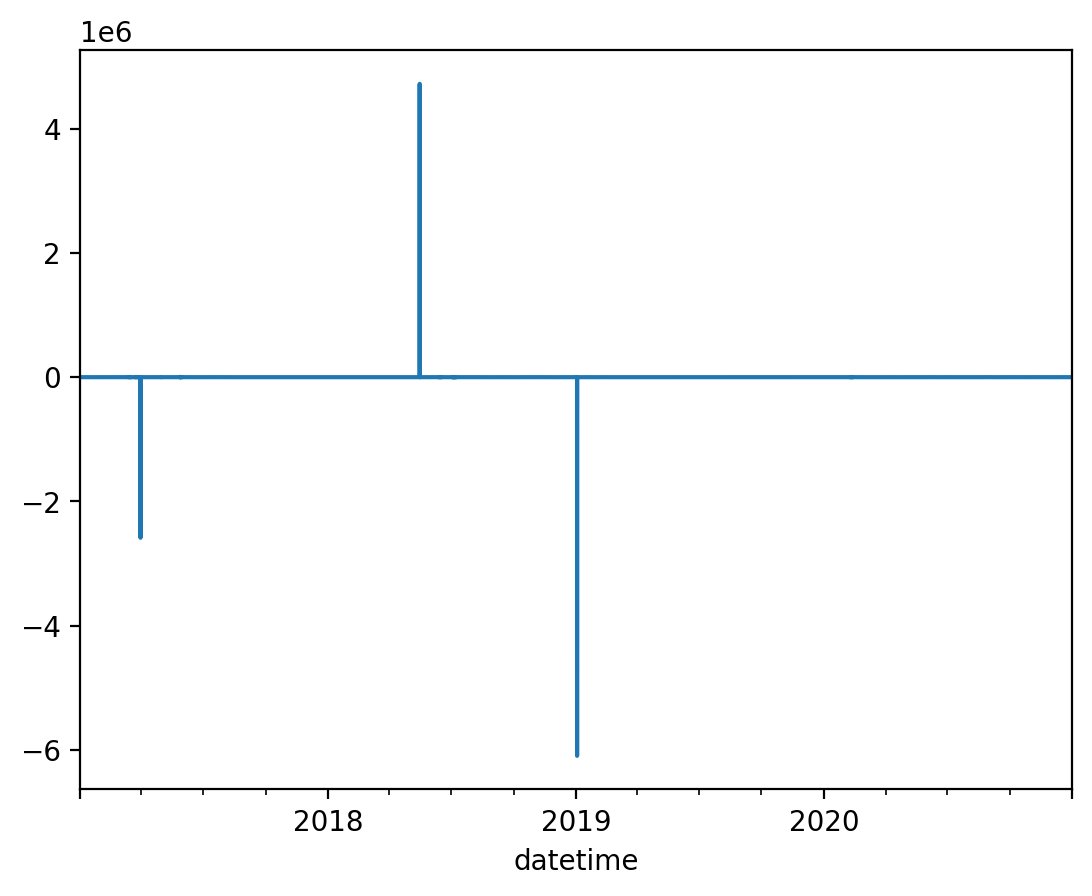

In [694]:
water.target.plot()

In [695]:
water.sort_values(by='target', ascending=False)

,target
datetime,
2018-05-15 20:00,4720655.0
2017-05-27 10:00,4999.0
2017-05-28 06:00,3357.0
2017-05-31 08:00,2591.0
2017-05-28 15:00,2550.0
...,...
2018-06-14 22:00,NaN
2018-07-04 12:00,NaN
2018-07-06 11:00,NaN


In [696]:
water.target = water.target.round(0)

In [697]:
water.target.replace(0, np.NaN, inplace=True)

<AxesSubplot:xlabel='datetime'>

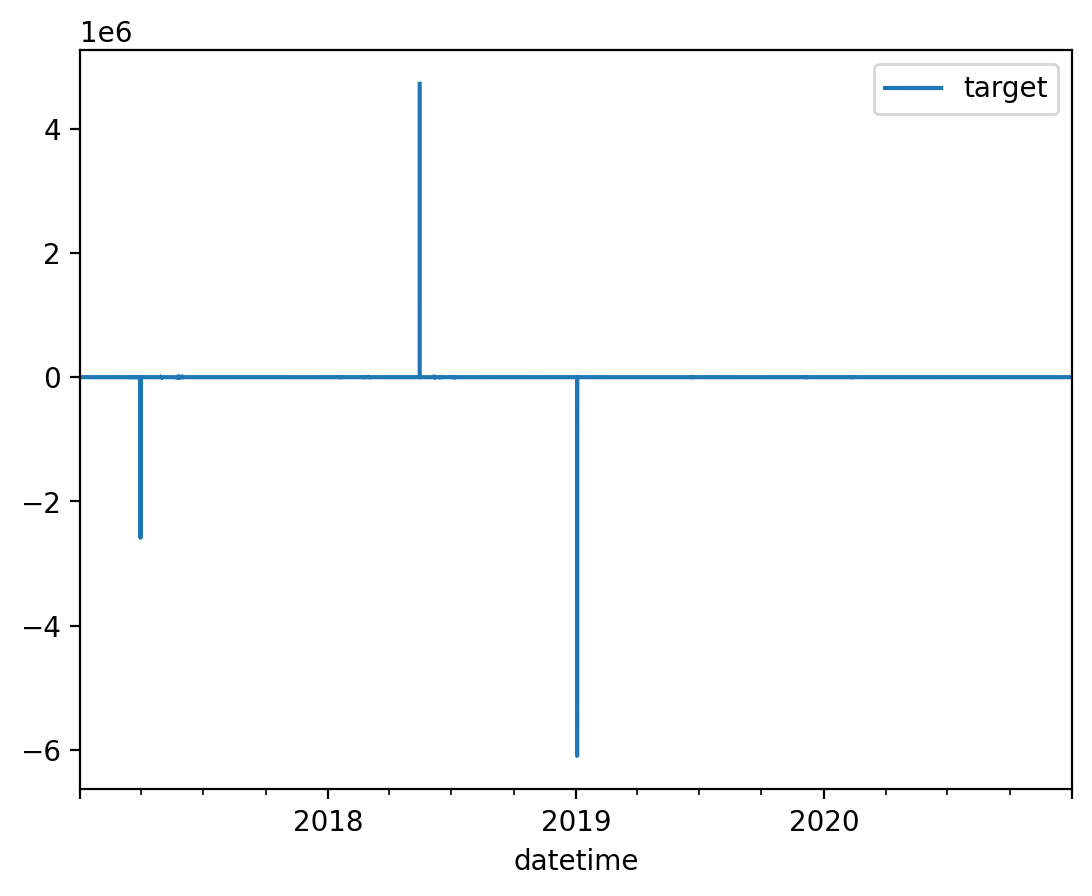

In [698]:
water.plot()

In [699]:
water[water.target == water.target.max()] = 0  # 위아래 평균값 넣기

In [701]:
for i in range(2):
    water[water.target == water.target.min()] = np.nan  # np.NaN

In [702]:
water[(water.index.year == 2017) & (water.index.month == 5) & (water.target.isna())]

,target
datetime,
2017-05-23 16:00,NaN
2017-05-23 18:00,NaN
2017-05-23 23:00,NaN
2017-05-24 21:00,NaN
2017-05-25 00:00,NaN
...,...
2017-05-31 03:00,NaN
2017-05-31 04:00,NaN
2017-05-31 05:00,NaN


### 5월 23일 결측치처리 - 진행중

In [851]:
print(water[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24) & (water.index.hour >= 14)])

                  target
datetime                
2017-05-23 14:00  684.00
2017-05-23 15:00  104.00
2017-05-23 16:00  269.04
2017-05-23 17:00  408.28
2017-05-23 18:00  180.50
2017-05-23 19:00  366.00
2017-05-23 20:00   56.00
2017-05-23 21:00  234.00
2017-05-23 22:00  486.00
2017-05-23 23:00     NaN
2017-05-24 14:00  303.00
2017-05-24 15:00  366.00
2017-05-24 16:00  154.00
2017-05-24 17:00  129.00
2017-05-24 18:00  171.00
2017-05-24 19:00  344.00
2017-05-24 20:00  175.00
2017-05-24 21:00     NaN
2017-05-24 22:00  670.00
2017-05-24 23:00  151.00


In [796]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 15) & (water.index.hour <= 17)])

                  target
datetime                
2017-05-23 15:00  104.00
2017-05-23 16:00  269.04
2017-05-23 17:00  408.28
2018-05-23 15:00  227.00
2018-05-23 16:00  133.00
2018-05-23 17:00  402.00
2019-05-23 15:00   84.00
2019-05-23 16:00  228.00
2019-05-23 17:00  346.00
2020-05-23 15:00  456.00
2020-05-23 16:00  260.00
2020-05-23 17:00  147.00


In [792]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 15) & (water.index.hour <= 17)].sum()

In [793]:
fill = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 15) & (water.index.hour <= 17)].sum()

In [794]:
print((filled / fill).round(2))

1.18


In [795]:
water[water.index == '2017-05-23 16:00'] = water.target[water.index == '2019-05-23 16:00'] * 1.18
water[water.index == '2017-05-23 17:00'] = water.target[water.index == '2019-05-23 17:00'] * 1.18

In [848]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 17) & (water.index.hour <= 19)])

                  target
datetime                
2017-05-23 17:00  408.28
2017-05-23 18:00  180.50
2017-05-23 19:00  366.00
2018-05-23 17:00  402.00
2018-05-23 18:00  179.00
2018-05-23 19:00  369.00
2019-05-23 17:00  346.00
2019-05-23 18:00  145.00
2019-05-23 19:00  319.00
2020-05-23 17:00  147.00
2020-05-23 18:00  293.00
2020-05-23 19:00  520.00


In [824]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 17) & (water.index.hour <= 19)].sum()
fill_1 = water.target[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 17) & (water.index.hour <= 19)].sum()
fill_2 = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 17) & (water.index.hour <= 19)].sum()

In [825]:
tot_fill = (fill_1+fill_2)/2

In [826]:
(filled/tot_fill).round(2)

0.88

In [846]:
(water.target[water.index == '2018-05-23 18:00'][0] + water.target[water.index == '2018-05-24 18:00'][0])/2

180.5

In [847]:
water[water.index == '2017-05-23 18:00'] = (
    water.target[water.index == '2018-05-23 18:00'][0] + water.target[water.index == '2018-05-24 18:00'][0])/2

<AxesSubplot:xlabel='datetime'>

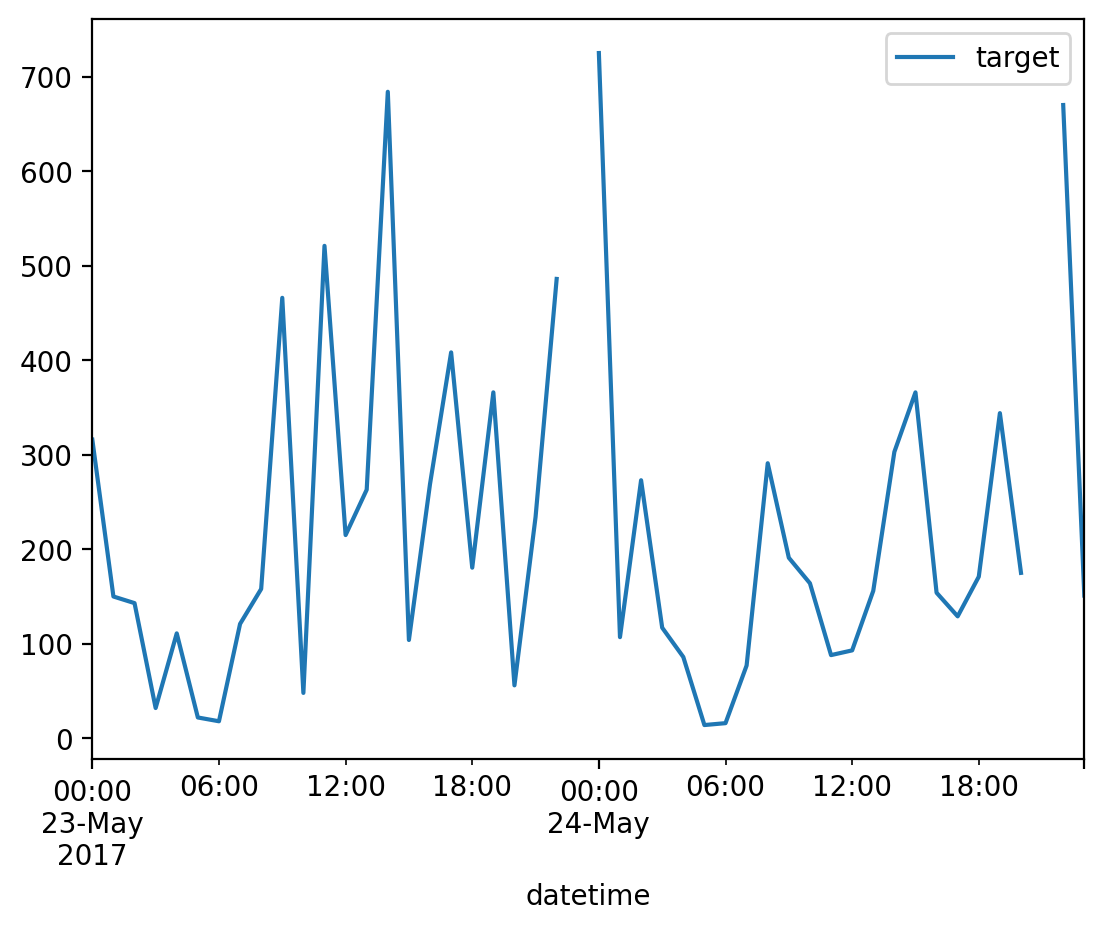

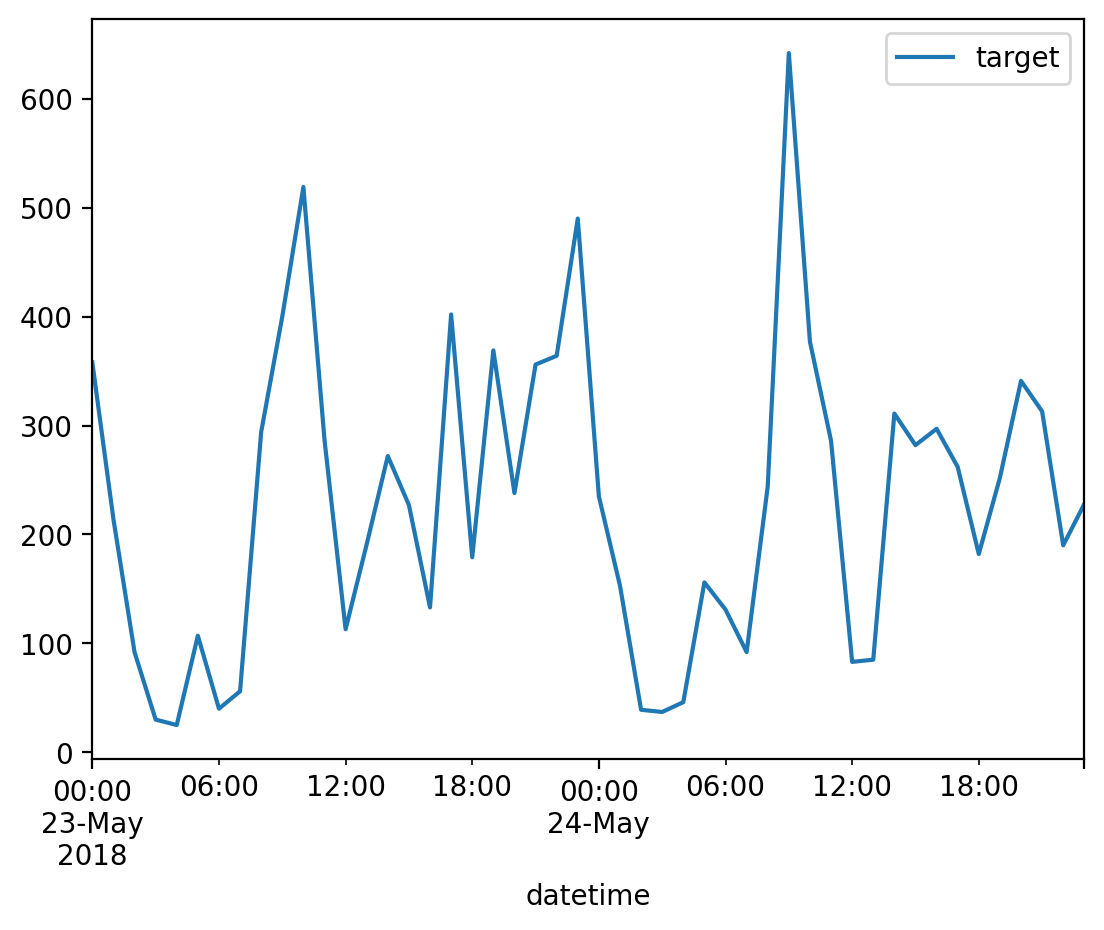

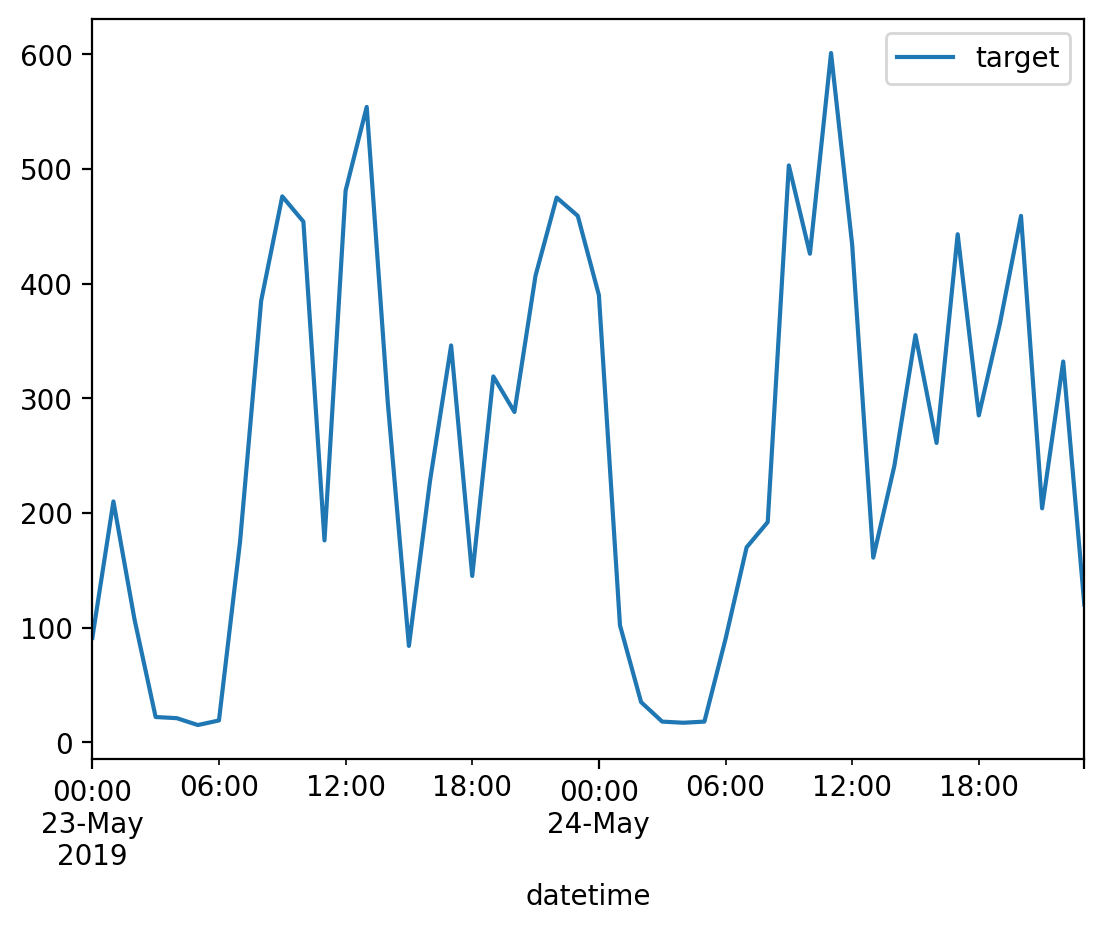

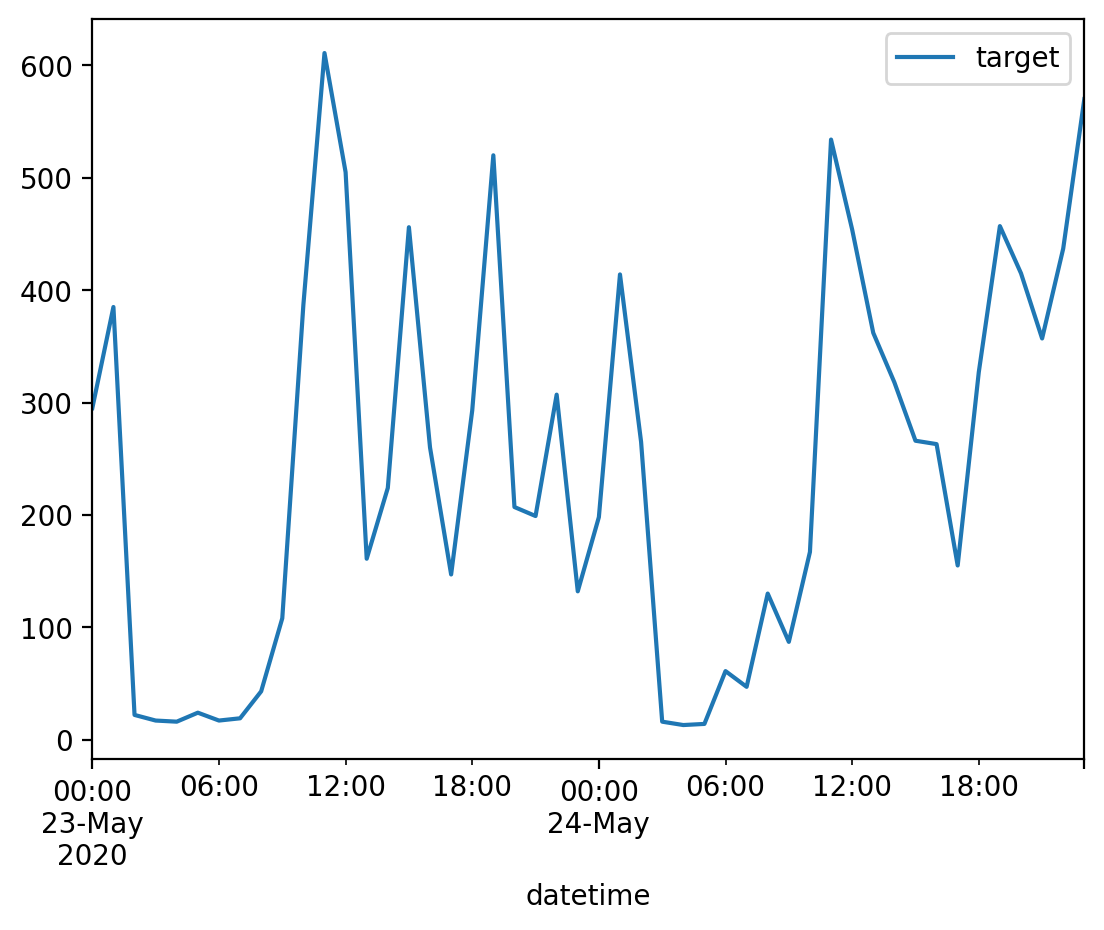

In [849]:
water[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2020) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()

In [706]:
water[(water.index.year == 2017) & (water.target.isna())]
# 보간법 일부 가능, 다른 년도의 값들을 보고 채워넣어야 할 듯.

,target
datetime,
2017-04-29 14:00,NaN
2017-04-29 16:00,NaN
2017-04-29 17:00,NaN
2017-04-29 18:00,NaN
2017-04-29 19:00,NaN
...,...
2017-05-31 03:00,NaN
2017-05-31 04:00,NaN
2017-05-31 05:00,NaN


In [705]:
water[(water.index.year == 2017) & (water.index.month == 3)] = water[
    (water.index.year == 2017) & (water.index.month == 3)].interpolate()

In [709]:
water[(water.index.year == 2018) & (water.target.isna())]
# 6월 6일의 결측값을 제외하고는 보간법이 가능함

,target
datetime,
2018-06-06 04:00,NaN
2018-06-06 05:00,NaN
2018-06-06 06:00,NaN
2018-06-06 07:00,NaN
2018-06-06 08:00,NaN
2018-06-06 12:00,NaN
2018-06-06 13:00,NaN
2018-06-06 14:00,NaN
2018-06-06 15:00,NaN


In [708]:
water[(water.index.year == 2018) & (water.index.month != 6)] = water[
    (water.index.year == 2018) & (water.index.month != 6)].interpolate()

In [712]:
water[(water.index.year == 2019) & (water.target.isna())]
# 보간법 사용가능

,target
datetime,


In [711]:
water[(water.index.year == 2019)] = water[(water.index.year == 2019)].interpolate()

In [715]:
water[(water.index.year == 2020) & (water.target.isna())]
# 각 결측치가 바로 붙어있긴 하지만 두개 밖에 없기 때문에 보간법 사용가능

,target
datetime,


In [714]:
water[(water.index.year == 2020)] = water[(water.index.year == 2020)].interpolate()

In [716]:
water[(water.index.year == 2021) & (water.target.isna())]
# 결측치 없음

,target
datetime,


In [717]:
water.target.isna().sum()

134